In [40]:
import tensorflow as tf
from keras import layers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import time


PROJECT_DIR = ".."
DATA_DIR = f"{PROJECT_DIR}/data/processed/PlantVillage_Binary"
LOGS_DIR = f"{PROJECT_DIR}/logs/disease_detection"

# Finetuning parameters
BATCH_SIZE = 32
IMG_SIDE_LENGTH = 128
IMG_SIZE = (IMG_SIDE_LENGTH, IMG_SIDE_LENGTH)
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 2
EPOCHS = 20
LR = 1e-4
LABEL_MODE = 'binary'

CLASS_WEIGHTS = None # Not required because both classes have equal images


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

GPU memory growth set to True


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"{DATA_DIR}/train",
    labels="inferred",
    label_mode=LABEL_MODE,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/val",
    labels="inferred",
    label_mode=LABEL_MODE,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/test",
    labels="inferred",
    label_mode=LABEL_MODE,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 46331 files belonging to 2 classes.


I0000 00:00:1756375001.778388   50095 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1741 MB memory:  -> device: 0, name: NVIDIA GeForce MX230, pci bus id: 0000:02:00.0, compute capability: 6.1


Found 21674 files belonging to 2 classes.
Found 15470 files belonging to 2 classes.


In [4]:
class_names = train_ds.class_names

print("Class names:", class_names)
print("Class 0 maps to:", class_names[0])
print("Class 1 maps to:", class_names[1])
# print("\nCurrent weights:")
# print(f"Class 0 ({class_names[0]}): {CLASS_WEIGHTS[0]:.3f}")
# print(f"Class 1 ({class_names[1]}): {CLASS_WEIGHTS[1]:.3f}")

Class names: ['Diseased', 'Healthy']
Class 0 maps to: Diseased
Class 1 maps to: Healthy


In [5]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.5),      
])

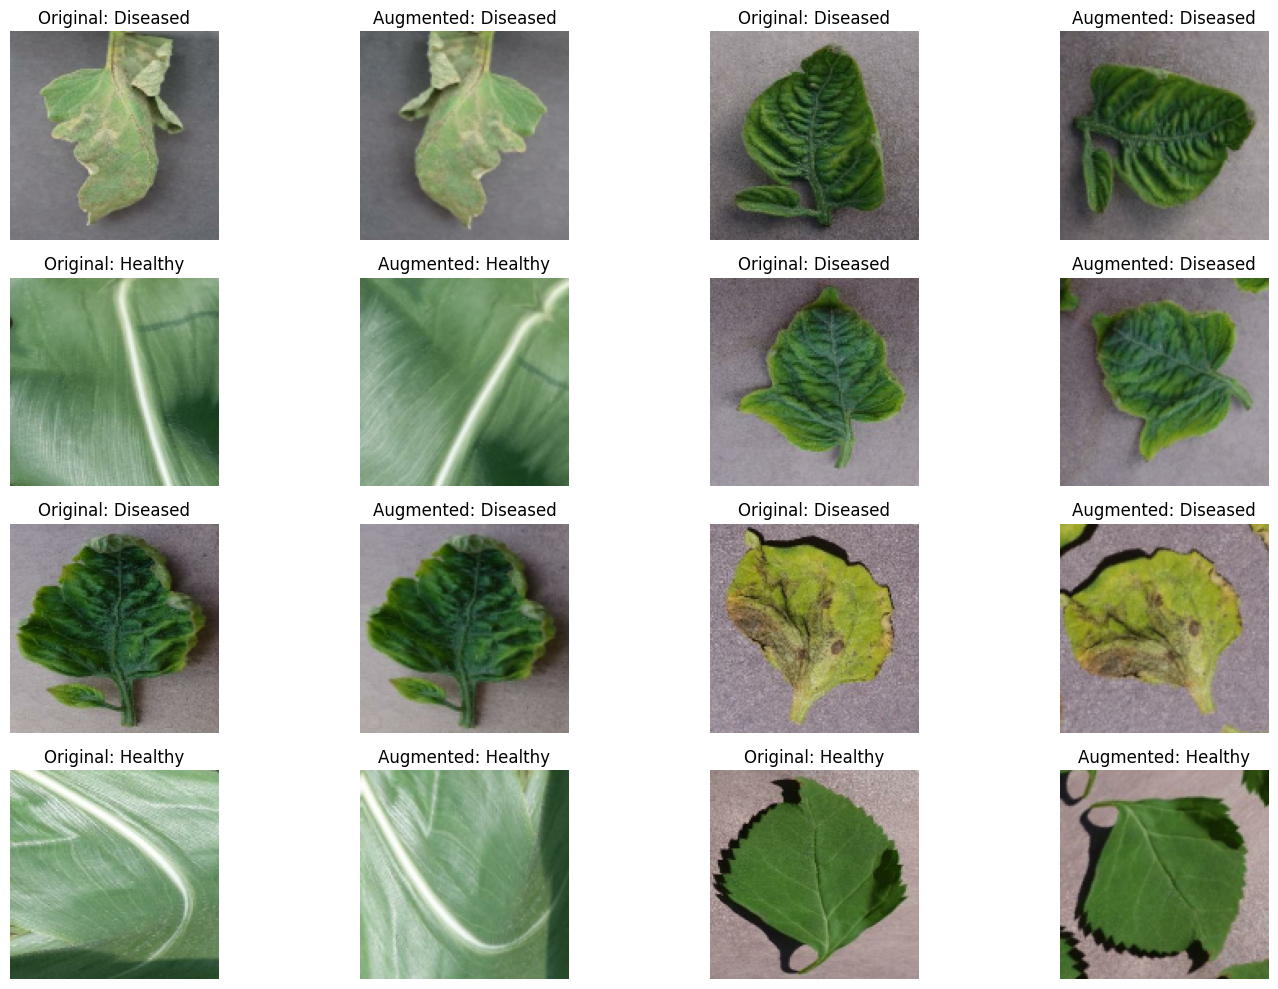


Class distribution in this batch:
Diseased: 27 images
Healthy: 5 images


In [6]:
# Visualize the augmented data with labels
import numpy as np

plt.figure(figsize=(15, 10))

# Get a batch of data
for images, labels in train_ds.take(1):
    # Take first 8 images from the batch
    for i in range(8):
        # Original image
        plt.subplot(4, 4, i*2 + 1)
        # Denormalize for display (since normalization_layer is applied in model)
        original_img = images[i].numpy().astype("uint8")
        plt.imshow(original_img)
        plt.title(f'Original: {class_names[int(labels[i])]}')
        plt.axis('off')
        
        # Augmented image
        plt.subplot(4, 4, i*2 + 2)
        # Apply data augmentation
        augmented_img = data_augmentation(tf.expand_dims(images[i], 0), training=True)
        augmented_img = tf.cast(augmented_img[0], tf.uint8).numpy()
        plt.imshow(augmented_img)
        plt.title(f'Augmented: {class_names[int(labels[i])]}')
        plt.axis('off')
    break

plt.tight_layout()
plt.show()

# Show distribution of classes in the current batch
unique, counts = np.unique(labels.numpy(), return_counts=True)
print(f"\nClass distribution in this batch:")
for class_idx, count in zip(unique, counts):
    print(f"{class_names[int(class_idx)]}: {count} images")

In [7]:
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=BUFFER_SIZE)
val_ds = val_ds.prefetch(buffer_size=BUFFER_SIZE)
test_ds = test_ds.prefetch(buffer_size=BUFFER_SIZE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIDE_LENGTH, IMG_SIDE_LENGTH, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # freeze base

model = tf.keras.Sequential([
    normalization_layer,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(IMG_SIDE_LENGTH, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
model.compile(optimizer=Adam(learning_rate=LR),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

In [11]:
# Define callbacks for better training control
import os

# Create models directory if it doesn't exist
os.makedirs(f"{PROJECT_DIR}/models", exist_ok=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
]

In [12]:
# Start timing
training_start_time = time.time()
print("Starting training...")

Starting training...


In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    class_weight=CLASS_WEIGHTS,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20


I0000 00:00:1756375018.329080   50772 service.cc:152] XLA service 0x63b49c5f2a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756375018.329104   50772 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX230, Compute Capability 6.1
2025-08-28 09:56:58.451474: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756375019.193049   50772 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1448 ━━━━━━━━━━━━━━━━━━━━ 1:29 62ms/step - accuracy: 0.6962 - loss: 0.6804 - precision: 0.4706 - recall: 0.3314

I0000 00:00:1756375029.259387   50772 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1448/1448 ━━━━━━━━━━━━━━━━━━━━ 173s 105ms/step - accuracy: 0.8812 - loss: 0.2756 - precision: 0.8211 - recall: 0.7129 - val_accuracy: 0.9423 - val_loss: 0.1545 - val_precision: 0.8426 - val_recall: 0.9325 - learning_rate: 1.0000e-04
Epoch 2/20
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 140s 93ms/step - accuracy: 0.9561 - loss: 0.1190 - precision: 0.9288 - recall: 0.9073 - val_accuracy: 0.9618 - val_loss: 0.1049 - val_precision: 0.9137 - val_recall: 0.9273 - learning_rate: 1.0000e-04
Epoch 3/20
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 142s 94ms/step - accuracy: 0.9648 - loss: 0.0935 - precision: 0.9407 - recall: 0.9284 - val_accuracy: 0.9588 - val_loss: 0.1111 - val_precision: 0.8748 - val_recall: 0.9652 - learning_rate: 1.0000e-04
Epoch 4/20
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 143s 95ms/step - accuracy: 0.9700 - loss: 0.0846 - precision: 0.9487 - recall: 0.9408 - val_accuracy: 0.9668 - val_loss: 0.0917 - val_precision: 0.9037 - val_recall: 0.9636 - learning_rate: 1.0000e-04
Epoch 5/20
1448/1448 ━━━━━━━━━━━━━━━━━

In [14]:
# End timing
training_end_time = time.time()
print(f"Training completed in {training_end_time - training_start_time:.2f} seconds")

Training completed in 2917.04 seconds


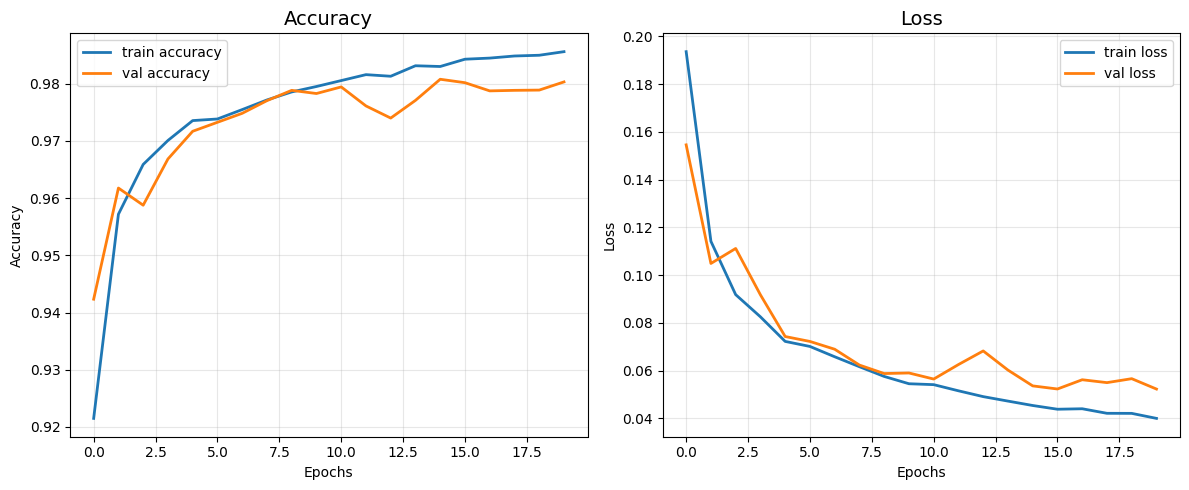

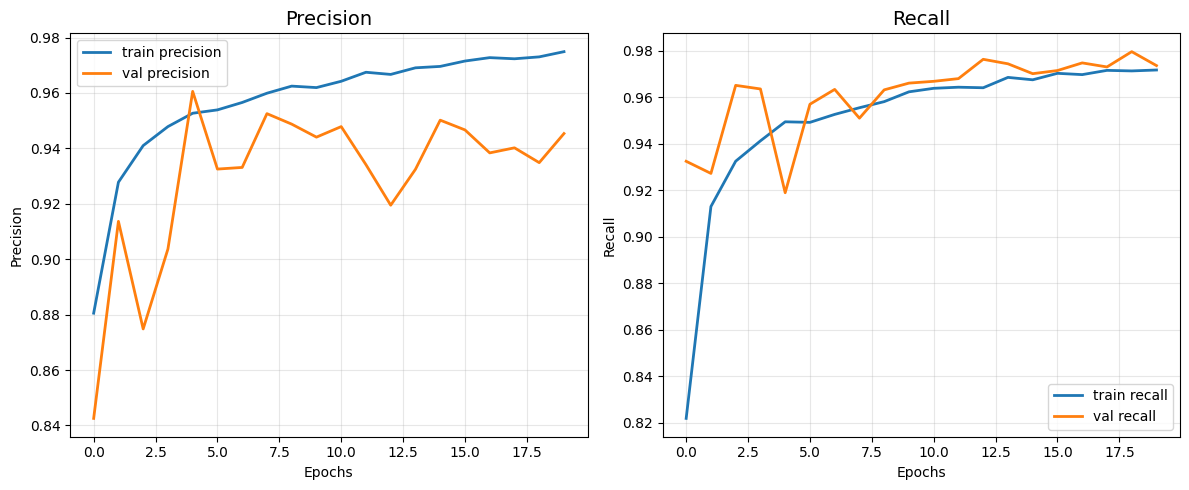

Train Accuracy: 0.9856
Validation Accuracy: 0.9803


In [34]:
# Minimal improvements to existing plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='val accuracy', linewidth=2)
plt.title('Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss', linewidth=2)
plt.plot(history.history['val_loss'], label='val loss', linewidth=2)
plt.title('Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['precision'], label='train precision', linewidth=2)
plt.plot(history.history['val_precision'], label='val precision', linewidth=2)
plt.title('Precision', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='train recall', linewidth=2)
plt.plot(history.history['val_recall'], label='val recall', linewidth=2)
plt.title('Recall', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

In [35]:
# Evaluate the model on the test dataset
test_results = model.evaluate(test_ds)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2] if len(test_results) > 2 else None
test_recall = test_results[3] if len(test_results) > 3 else None

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
if test_precision is not None:
    print(f"Test Precision: {test_precision}")
if test_recall is not None:
    print(f"Test Recall: {test_recall}")

  1/484 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 1.0000 - loss: 0.0081 - precision: 0.0000e+00 - recall: 0.0000e+00

484/484 ━━━━━━━━━━━━━━━━━━━━ 32s 66ms/step - accuracy: 0.9824 - loss: 0.0487 - precision: 0.1903 - recall: 0.2252
Test Loss: 0.053000111132860184
Test Accuracy: 0.9796379804611206
Test Precision: 0.9409655332565308
Test Recall: 0.9712414741516113
484/484 ━━━━━━━━━━━━━━━━━━━━ 32s 66ms/step - accuracy: 0.9824 - loss: 0.0487 - precision: 0.1903 - recall: 0.2252
Test Loss: 0.053000111132860184
Test Accuracy: 0.9796379804611206
Test Precision: 0.9409655332565308
Test Recall: 0.9712414741516113


In [36]:
# Load and preprocess your custom image
from keras.utils import load_img, img_to_array
import numpy as np

# Path to your custom image
custom_image_path_healthy = f"../data/custom/image.png" 
custom_image_path_diseased = f"../data/custom/bp_diseased.jpg" 

diseased_image = load_img(custom_image_path_diseased, target_size=IMG_SIZE)
diseased_image_array = img_to_array(diseased_image)
diseased_image_array = np.expand_dims(diseased_image_array, axis=0)
diseased_image_array = diseased_image_array / 255.0

healthy_image = load_img(custom_image_path_healthy, target_size=IMG_SIZE)
healthy_image_array = img_to_array(healthy_image)
healthy_image_array = np.expand_dims(healthy_image_array, axis=0)
healthy_image_array = healthy_image_array / 255.0

healthy_predictions = model.predict(healthy_image_array)
diseased_predictions = model.predict(diseased_image_array)

print("Raw predictions:")
print(f"Healthy image raw score: {healthy_predictions[0][0]:.4f}")
print(f"Diseased image raw score: {diseased_predictions[0][0]:.4f}")
print()

predicted_healthy_class = (healthy_predictions[0][0] > 0.1).astype(int)
predicted_diseased_class = (diseased_predictions[0][0] > 0.1).astype(int)

print(f"Healthy Image Prediction: {class_names[predicted_healthy_class]} (Score: {healthy_predictions[0][0]:.4f})")
print(f"Diseased Image Prediction: {class_names[predicted_diseased_class]} (Score: {diseased_predictions[0][0]:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Raw predictions:
Healthy image raw score: 0.7578
Diseased image raw score: 0.7614

Healthy Image Prediction: Healthy (Score: 0.7578)
Diseased Image Prediction: Healthy (Score: 0.7614)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Raw predictions:
Healthy image raw score: 0.7578
Diseased image raw score: 0.7614

Healthy Image Prediction: Healthy (Score: 0.7578)
Diseased Image Prediction: Healthy (Score: 0.7614)


In [37]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import numpy as np

# Get predictions for test set
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Get true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Calculate metrics
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

484/484 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step
484/484 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step
F1 Score: 0.9559
Precision: 0.9410
Recall: 0.9712

Classification Report:
              precision    recall  f1-score   support

    Diseased       0.99      0.98      0.99     11958
     Healthy       0.94      0.97      0.96      3512

    accuracy                           0.98     15470
   macro avg       0.97      0.98      0.97     15470
weighted avg       0.98      0.98      0.98     15470

F1 Score: 0.9559
Precision: 0.9410
Recall: 0.9712

Classification Report:
              precision    recall  f1-score   support

    Diseased       0.99      0.98      0.99     11958
     Healthy       0.94      0.97      0.96      3512

    accuracy                           0.98     15470
   macro avg       0.97      0.98      0.97     15470
weighted avg       0.98      0.98      0.98     15470



2025-08-28 10:56:24.157972: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
# Training Run Logger
import json
import datetime
import os

# Create logs directory if it doesn't exist
os.makedirs(LOGS_DIR, exist_ok=True)

# Calculate training time (assuming you stored start time before training)
# If you didn't store start time, you can estimate from history length
try:
    training_time_seconds = training_end_time - training_start_time
except NameError:
    # Estimate based on epochs (rough approximation)
    epochs_completed = len(history.history['accuracy'])
    estimated_time_per_epoch = 60  # seconds (adjust based on your setup)
    training_time_seconds = epochs_completed * estimated_time_per_epoch

training_time_minutes = training_time_seconds / 60
training_time_hours = training_time_minutes / 60

# Prepare training log data
training_log = {
    "timestamp": datetime.datetime.now().isoformat(),
    "hyperparameters": {
        "batch_size": BATCH_SIZE,
        "img_side_length": IMG_SIDE_LENGTH,
        "epochs": EPOCHS,
        "learning_rate": LR,
        "buffer_size": BUFFER_SIZE,
        "label_mode": LABEL_MODE,
        "class_weights": CLASS_WEIGHTS,
        "data_augmentation": "RandomFlip(horizontal) + RandomRotation(0.5)",
        "base_model": "MobileNetV2",
        "base_model_trainable": False,
        "optimizer": "Adam",
        "loss": "binary_crossentropy",
        "dropout_rate": 0.3,
        "dense_layer_units": IMG_SIDE_LENGTH
    },
    "dataset_info": {
        "data_dir": DATA_DIR,
        "class_names": class_names,
        "total_classes": len(class_names)
    },
    "callbacks": {
        "early_stopping": {
            "monitor": "val_loss",
            "patience": 5,
            "restore_best_weights": True
        },
        "reduce_lr_on_plateau": {
            "monitor": "val_loss",
            "factor": 0.5,
            "patience": 3,
            "min_lr": 1e-7
        }
    },
    "training_time": {
        "total_seconds": float(training_time_seconds),
        "total_minutes": float(training_time_minutes),
        "total_hours": float(training_time_hours),
        "formatted": f"{int(training_time_hours):02d}h {int(training_time_minutes % 60):02d}m {int(training_time_seconds % 60):02d}s"
    },
    "results": {
        "final_train_accuracy": float(history.history['accuracy'][-1]),
        "final_val_accuracy": float(history.history['val_accuracy'][-1]),
        "final_train_loss": float(history.history['loss'][-1]),
        "final_val_loss": float(history.history['val_loss'][-1]),
        "best_val_accuracy": float(max(history.history['val_accuracy'])),
        "best_val_loss": float(min(history.history['val_loss'])),
        "epochs_trained": len(history.history['accuracy']),
        "test_accuracy": float(test_accuracy),
        "test_loss": float(test_loss),
        "test_f1_score": float(f1),
        "test_precision": float(precision),
        "test_recall": float(recall)    
    },
    "training_history": {
        "accuracy": [float(x) for x in history.history['accuracy']],
        "val_accuracy": [float(x) for x in history.history['val_accuracy']],
        "loss": [float(x) for x in history.history['loss']],
        "val_loss": [float(x) for x in history.history['val_loss']]
    },
    "custom_predictions": {
        "healthy_image_score": float(healthy_predictions[0][0]),
        "diseased_image_score": float(diseased_predictions[0][0]),
        "healthy_image_prediction": class_names[predicted_healthy_class],
        "diseased_image_prediction": class_names[predicted_diseased_class]
    }
}

# Save to JSON file with timestamp
timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_filename = f"{LOGS_DIR}/training_log_{timestamp_str}.json"

with open(log_filename, 'w') as f:
    json.dump(training_log, f, indent=2)

print(f"Training log saved to: {log_filename}")

# Print summary
print("\n=== TRAINING SUMMARY ===")
print(f"Model: MobileNetV2 (frozen) + Dense({IMG_SIDE_LENGTH}) + Dense(1)")
print(f"Training Time: {training_log['training_time']['formatted']}")
print(f"Final Training Accuracy: {training_log['results']['final_train_accuracy']:.4f}")
print(f"Final Validation Accuracy: {training_log['results']['final_val_accuracy']:.4f}")
print(f"Test Accuracy: {training_log['results']['test_accuracy']:.4f}")
print(f"Test F1 Score: {training_log['results']['test_f1_score']:.4f}")
print(f"Epochs Trained: {training_log['results']['epochs_trained']}")
print(f"Best Validation Accuracy: {training_log['results']['best_val_accuracy']:.4f}")
print(f"Learning Rate: {LR}")
print(f"Batch Size: {BATCH_SIZE}")

Training log saved to: ../logs/disease_detection/training_log_20250828_105819.json

=== TRAINING SUMMARY ===
Model: MobileNetV2 (frozen) + Dense(128) + Dense(1)
Training Time: 00h 48m 37s
Final Training Accuracy: 0.9856
Final Validation Accuracy: 0.9803
Test Accuracy: 0.9796
Test F1 Score: 0.9559
Epochs Trained: 20
Best Validation Accuracy: 0.9808
Learning Rate: 0.0001
Batch Size: 32


In [39]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open(f"{PROJECT_DIR}/models/plant_disease__binary_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model successfully converted to TFLite format!")

INFO:tensorflow:Assets written to: /tmp/tmpqqrx9pbg/assets


INFO:tensorflow:Assets written to: /tmp/tmpqqrx9pbg/assets


Saved artifact at '/tmp/tmpqqrx9pbg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_157')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  123230162699472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123230162701776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123230162700048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123230162701200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123230162700432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123230162700240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123230162702544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123230162702352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123230162701008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123230162703120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1232301627

W0000 00:00:1756378592.892864   50095 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1756378592.892886   50095 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-08-28 10:56:32.893089: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqqrx9pbg
2025-08-28 10:56:32.907800: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-28 10:56:32.907820: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpqqrx9pbg
2025-08-28 10:56:33.057314: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-28 10:56:33.833821: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpqqrx9pbg
2025-08-28 10:56:34.052259: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 1159173 microseconds.
